In [110]:
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn as sk
import sklearn.datasets
from scipy.stats import mode
%matplotlib inline
# Ensure that you're using unix newlines
# with open('./results', 'w', newline='\n') as file_out:

In [102]:
def one_hot_vector(x):
    v = [0] * 10
    v[int(x)] = 1
    return v

def read(path):
    X, y = sklearn.datasets.load_svmlight_file(path, 784, dtype=np.float32)
    return dict(images=X.todense(), origLabels=y, labels=[one_hot_vector(x) for x in y])

data = dict(train=read('digits/digit_train'), test=read('digits/digit_test'))

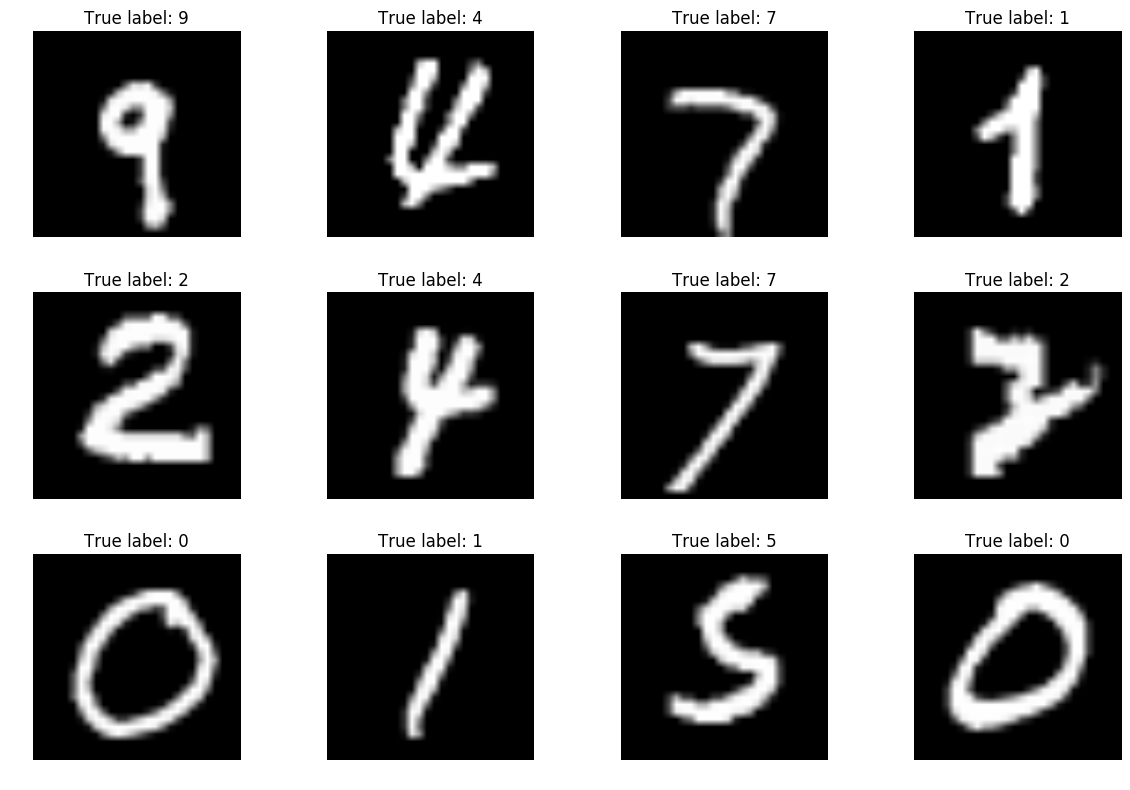

In [103]:
# Exercise 11.1.a
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i, ax in enumerate(axes.flat):
    img = data['train']['images'][i].reshape(28, 28)
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title('True label: {:.0f}'.format(data['train']['origLabels'][i]))
fig.tight_layout()

In [147]:
# Using the MNIST tutorial from Tensorflow (optimized for the real MNIST dataset)
# Create the model
x = tf.placeholder(tf.float32, [None, 784])
W = tf.Variable(tf.zeros([784, 10]))
b = tf.Variable(tf.zeros([10]))
y = tf.matmul(x, W) + b

# Define loss and optimizer
y_ = tf.placeholder(tf.float32, [None, 10])
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y, y_))
train_step = tf.train.ProximalGradientDescentOptimizer(.5).minimize(cross_entropy)

sess = tf.InteractiveSession()
tf.global_variables_initializer().run()
# Train
sess.run(train_step, feed_dict={x: data['train']['images'], y_: data['train']['labels']})

# Test trained model
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print('Accuracy:', sess.run(accuracy, feed_dict={x: data['test']['images'], y_: data['test']['labels']}))
# -> not working well for small dataset

Accuracy: 0.114


In [197]:
# KNN on MNIST (http://steven.codes/blog/ml/how-to-get-97-percent-on-MNIST-with-KNN/)
def svd_pca(data, k):
    """Reduce DATA using its K principal components."""
    data = data.astype("float64")
    data -= np.mean(data, axis=0)
    U, S, V = np.linalg.svd(data, full_matrices=False)
    return U[:,:k].dot(np.diag(S)[:k, :k])

class KNN:
    def __init__(self, data, labels, k):
        self.data = data
        self.labels = labels
        self.k = k

    def predict(self, sample):
        differences = (self.data - sample)
        distances = np.einsum('ij, ij->i', differences, differences)
        nearest = self.labels[np.argsort(distances)[:self.k]]
        return mode(nearest)[0][0]

train_data = data['train']['images']
test_data = data['test']['images']
'''
dataset = svd_pca(np.concatenate([train_data, test_data]), 2)
train_data = dataset[:500]
test_data = dataset[500:]
'''
knn = KNN(train_data, data['train']['origLabels'], 10)
successes = 0
for i in range(100):
    y = knn.predict(test_data[i])
    yT = data['test']['origLabels'][i]
    if int(y) == int(yT):
        successes += 1
print('Accuracy:', successes / 100)

Accuracy: 0.14
